In [1]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
import json
import os

d:\.exe\miniconda\envs\dp\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
if 'COLAB_GPU' in os.environ:
    print('Running on Colab')

    from google.colab import drive
    drive.mount('/content/drive')

    checkpoint_model_filepath = '/content/drive/MyDrive/DP/1m/training/checkpoints/'
    # checkpoint_model_extension = '.keras'
    project_path = '/content/drive/MyDrive/DP/'
    training_data_path = '/content/drive/MyDrive/DP/1m/training/data/'
    nn_config_path = '/content/drive/MyDrive/DP/config/nn_config.json'
    wandb_config_path = '/content/drive/MyDrive/DP/config/wandb_config.json'

    !cp drive/MyDrive/DP/1m/training/nn_model.py .

else:
    print('Running locally')
    
    checkpoint_model_filepath = 'checkpoints/'
    trained_model_filepath = 'trained_models/'
    # checkpoint_model_extension = '.keras'
    # project_path = '/content/drive/MyDrive/DP/'
    training_data_path = 'data/'
    nn_config_path = '../../config/nn_config.json'
    wandb_config_path = '../../config/wandb_config.json'

import nn_model

Running locally


In [3]:
try:
  with open(wandb_config_path, 'r') as f:
    wandb_config = json.load(f)

  # wandb_log = bool(wandb_config["wandb_log"])
  if wandb_config["wandb_log"] == 'false':
    wandb_log = False
  else:
    wandb_log = True
  wandb_run_name = wandb_config["wandb_run_name"]
  wandb_group_name = wandb_config["wandb_group_name"]
  wandb_entity = wandb_config["wandb_entity"]
  wandb_project_name = wandb_config["wandb_project_name"]
  # new_model = bool(wandb_config["new_model"])         # If True, train a new model. If False, load a pretrained model
  if wandb_config["new_model"] == 'false':
    new_model = False
  else:
    new_model = True
  run_name_before = wandb_config["run_name_before"]   # Model to be loaded
  # eval_only = bool(wandb_config["eval_only"]) # If True, load a pretrained model and perform test and eval
  if wandb_config["eval_only"] == 'false':
    eval_only = False
  else:
    eval_only = True

  print('wandb_log:', wandb_log)
  print('wandb_run_name:', wandb_run_name)
  print('wandb_group_name:', wandb_group_name)
  print('wandb_entity:', wandb_entity)
  print('wandb_project_name:', wandb_project_name)
  print('new_model:', new_model)
  print('run_name_before:', run_name_before)
  print('eval_only:', eval_only)

except OSError as e:
  print('\nERROR loading wandb_config file')
  print(e)
  # quit()

wandb_log: True
wandb_run_name: arch4_fs_mi
wandb_group_name: Dense
wandb_entity: xbarantomik
wandb_project_name: DP
new_model: True
run_name_before: -
eval_only: False


In [4]:
try:
  with open(nn_config_path, 'r') as f:
    nn_config = json.load(f)

  epochs = int(nn_config['epochs'])
  batch_size = int(nn_config['batch_size'])
  patience = int(nn_config['patience'])
  learning_rate = float(nn_config['learning_rate'])
  architecture = int(nn_config['architecture'])
  training_data_file = nn_config['training_data_file'] + '/'

  print('epochs:', epochs)
  print('batch_size:', batch_size)
  print('patience:', patience)
  print('learning_rate:', learning_rate)
  print('architecture:', architecture)
  print('training_data_file:', training_data_file)

except OSError as e:
  print('\nERROR loading nn_config file')
  print(e)
  # quit()

epochs: 35
batch_size: 128
patience: 7
learning_rate: 0.001
architecture: 4
training_data_file: mi_context_data/


#### Load training data

In [5]:
try:
  train_data = np.load(training_data_path + training_data_file + 'train_data.npy')
  val_data = np.load(training_data_path + training_data_file + 'val_data.npy')
  test_data = np.load(training_data_path + training_data_file + 'test_data.npy')
  train_target_ratings = np.load(training_data_path + training_data_file + 'train_target_ratings.npy')
  val_target_ratings = np.load(training_data_path + training_data_file + 'val_target_ratings.npy')
  test_target_ratings = np.load(training_data_path + training_data_file + 'test_target_ratings.npy')

except OSError as e:
  print('\nERROR loading training data')
  print(e)
  quit()

In [6]:
if wandb_log and 'COLAB_GPU' in os.environ:
  !pip install wandb
  # !wandb login --relogin

In [7]:
if wandb_log:
  import wandb
  from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

  wandb.login()

  wandb.init(
    config=nn_config,
    entity=wandb_entity,
    project=wandb_project_name,
    name=wandb_run_name,
    group=wandb_group_name
  )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: xbarantomik. Use `wandb login --relogin` to force relogin


#### NN MODEL

In [8]:
early_stopping = EarlyStopping(patience=patience, monitor='val_loss')

In [9]:
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     learning_rate,
#     decay_steps=75,
#     decay_rate=0.96,
#     staircase=True)

In [10]:
# KEEP THE COMMENTS HERE (for now)
# scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

checkpoint_filepath = checkpoint_model_filepath + f"{wandb_run_name}_checkpoint.h5"

checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', save_best_only=True, mode='min', save_weights_only=False, save_format='tf')

if wandb_log:
  # callbacks = [early_stopping, checkpoint_callback, OutputCallback(), WandbMetricsLogger()]
  # callbacks = [early_stopping, scheduler, WandbMetricsLogger()]
  callbacks = [early_stopping, checkpoint_callback, WandbMetricsLogger()]
  # callbacks = [early_stopping, WandbMetricsLogger()]
else:
  # callbacks = [early_stopping, checkpoint_callback, OutputCallback()]
  # callbacks = [early_stopping, scheduler]
  callbacks = [early_stopping, checkpoint_callback]
  # callbacks = [early_stopping]

#### Create model

In [11]:
# time_steps = 1
# train_data_reshaped = np.reshape(train_data, (train_data.shape[0], time_steps, train_data.shape[1]))

# train_data_reshaped.shape[1:]

# # my_model = nn_model.create_model(architecture=architecture, train_data_shape=train_data.shape[1])
# my_model = nn_model.create_model(architecture=architecture, train_data_shape=train_data_reshaped.shape[1:])

# if my_model != None:
#   my_model.summary()
# else:
#   print('\nERROR loading NN model')
#   quit()

In [12]:
if new_model:
  my_model = nn_model.create_model(architecture=architecture, lr=learning_rate, train_data_shape=train_data.shape[1])
  print('\nCreated a new model')
else:
  my_model = load_model(checkpoint_model_filepath + run_name_before + '_checkpoint.h5')
  print('\nLoaded a model')

if my_model != None:
  my_model.summary()
else:
  print('\nERROR loading NN model')
  quit()

Model 4

Created a new model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               10752     
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)       

## Model fitting

In [13]:
if not eval_only:
  print('Training model')
  trained_model = my_model.fit(train_data, train_target_ratings, batch_size, epochs, validation_data=(val_data, val_target_ratings), callbacks=callbacks, verbose=1)
  my_model.save(trained_model_filepath + f"{wandb_run_name}_trained.keras")
else:
  print('Only evaluating model')

Training model
Epoch 1/35
6250/6252 [============================>.] - ETA: 0s - loss: 1.2158 - root_mean_squared_error: 1.1026 - mean_absolute_error: 0.8942

d:\.exe\miniconda\envs\dp\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6252/6252 [==============================] - 81s 13ms/step - loss: 1.2158 - root_mean_squared_error: 1.1026 - mean_absolute_error: 0.8942 - val_loss: 1.1261 - val_root_mean_squared_error: 1.0612 - val_mean_absolute_error: 0.8615
Epoch 2/35
6252/6252 [==============================] - 57s 9ms/step - loss: 1.1436 - root_mean_squared_error: 1.0694 - mean_absolute_error: 0.8677 - val_loss: 1.1141 - val_root_mean_squared_error: 1.0555 - val_mean_absolute_error: 0.8564
Epoch 3/35
6252/6252 [==============================] - 56s 9ms/step - loss: 1.1252 - root_mean_squared_error: 1.0608 - mean_absolute_error: 0.8600 - val_loss: 1.1047 - val_root_mean_squared_error: 1.0511 - val_mean_absolute_error: 0.8575
Epoch 4/35
6252/6252 [==============================] - 55s 9ms/step - loss: 1.1130 - root_mean_squared_error: 1.0550 - mean_absolute_error: 0.8548 - val_loss: 1.0943 - val_root_mean_squared_error: 1.0461 - val_mean_absolute_error: 0.8485
Epoch 5/35
6252/6252 [==============================] 

#### After fitting


----------- Loss chart -----------



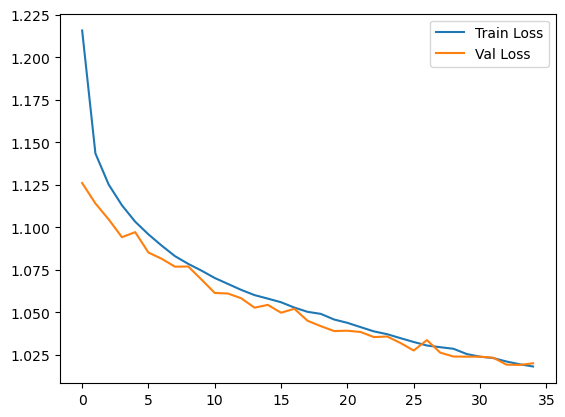


----------- RootMSE chart -----------



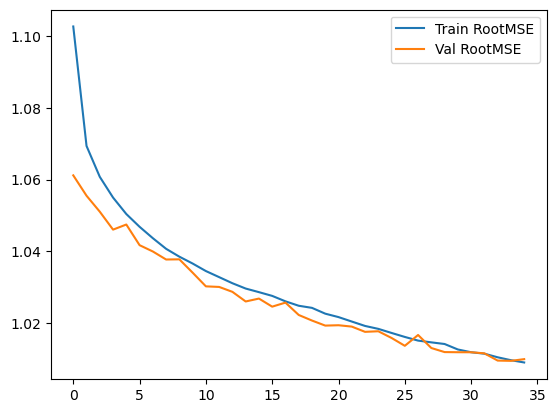


----------- MAE chart -----------



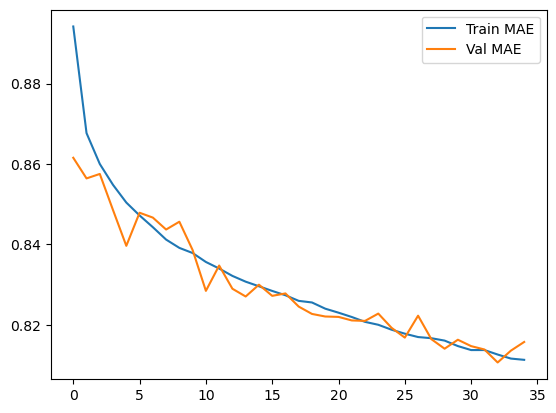

In [14]:
metric_name = ['Loss', 'RootMSE', 'MAE']
train_metric = ['loss', 'root_mean_squared_error', 'mean_absolute_error']
val_metric = ['val_loss', 'val_root_mean_squared_error', 'val_mean_absolute_error']

for i in range(len(metric_name)):

  print(f"\n----------- {metric_name[i]} chart -----------\n")

  # plotly chart
  fig_loss = px.line({
    'Epoch' : range(1, len(trained_model.history[train_metric[i]]) + 1),
    f"Train {metric_name[i]}": trained_model.history[train_metric[i]],
    f"Val {metric_name[i]}": trained_model.history[val_metric[i]]
    },
    title=f"Train vs Val {metric_name[i]}", x='Epoch', y=[f"Train {metric_name[i]}", f"Val {metric_name[i]}"])
  fig_loss.show()

  # matplotlib chart
  plt.plot(trained_model.history[train_metric[i]], label=f"Train {metric_name[i]}")
  plt.plot(trained_model.history[val_metric[i]], label=f"Val {metric_name[i]}")
  plt.legend()
  plt.show()

In [15]:
# Validation data values in the last epoch
print("number of epochs:", trained_model.epoch[-1] + 1)
print("val_loss:", trained_model.history['val_loss'][-1])
print("val_root_mean_squared_error:", trained_model.history['val_root_mean_squared_error'][-1])
print("val_mean_absolute_error:", trained_model.history['val_mean_absolute_error'][-1])

number of epochs: 35
val_loss: 1.02012300491333
val_root_mean_squared_error: 1.0100114345550537
val_mean_absolute_error: 0.8157013058662415


In [16]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
test_loss, test_mean_squared_error, test_mean_absolute_error = my_model.evaluate(test_data, test_target_ratings)
print("Test_loss:", test_loss)
print("Test_root_mean_squared_error:", test_mean_squared_error)
print("Test_mean_absolute_error:", test_mean_absolute_error)
print('\n')

print("Generate predictions for 10 samples")
predictions = my_model.predict(test_data)
test_y_comparison = pd.DataFrame({'test_y_true': test_target_ratings, 'test_y_pred': [x for x in predictions]})

print(test_y_comparison.head(10))

Evaluate on test data
3126/3126 [==============================] - 7s 2ms/step - loss: 1.0220 - root_mean_squared_error: 1.0109 - mean_absolute_error: 0.8170
Test_loss: 1.021974802017212
Test_root_mean_squared_error: 1.010927677154541
Test_mean_absolute_error: 0.8170343637466431


Generate predictions for 10 samples
3126/3126 [==============================] - 8s 2ms/step
   test_y_true  test_y_pred
0            4  [3.5289457]
1            3  [2.6283684]
2            5  [3.8036604]
3            5   [3.774525]
4            4  [3.4761384]
5            4  [3.5259078]
6            4   [4.029824]
7            3  [4.0401735]
8            1  [3.3804765]
9            5    [4.02998]


In [17]:
if wandb_log:
  wandb.finish()

epoch/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch/mean_absolute_error,█▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch/root_mean_squared_error,█▆▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▇▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/val_mean_absolute_error,█▇▇▆▅▆▆▆▆▅▃▄▄▃▄▃▃▃▃▃▃▂▂▃▂▂▃▂▁▂▂▁▁▁▂
epoch/val_root_mean_squared_error,█▇▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/epoch,34
epoch/learning_rate,0.001
epoch/loss,1.01825
